In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from base import PromptAttn, p_svm_solver

In [2]:
n = 2
T = 2
d = 3
ITN = 1000

loss_type = ['-x', 'log']
Cs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 100]
ps = np.zeros((len(loss_type), len(Cs), ITN, d))


def data_generator(C):
    v = torch.tensor([0,0,1])
    Y = torch.tensor([1,1])
    X = torch.tensor([
        [[0,0,0],[1.,1.,C]],
        [[0,0,0],[1.,-1.,1]],
    ])
    return X, Y, v

In [3]:
for i in range(len(loss_type)):
    for j in range(len(Cs)):
        X, Y, v = data_generator(Cs[j])
        model = PromptAttn(d, identity_W=False)
        model.key.weight.data   = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
        model.query.weight.data = torch.tensor([[1.,0,0],[0,1.,0], [0,0,0]])
        model.prompt.data = torch.zeros(d)
        model.w.data = torch.tensor(np.array(v)).float().view(-1)
        optimizer = torch.optim.SGD([model.prompt], lr=0.1)
        for it in range(ITN):
            ps[i,j,it] = model.prompt.detach().numpy()
            optimizer.zero_grad()    
            if loss_type[i] == '-x':
                loss = -Y*model(X)
            elif loss_type[i] == 'exp':
                loss = torch.exp(-Y*model(X))
            elif loss_type[i] == 'log':
                loss = torch.log(1+torch.exp(-Y*model(X)))
            loss = loss.mean()
            loss.backward()
            model.prompt.grad /= (model.prompt.grad.norm()+0.000000001)
            optimizer.step()


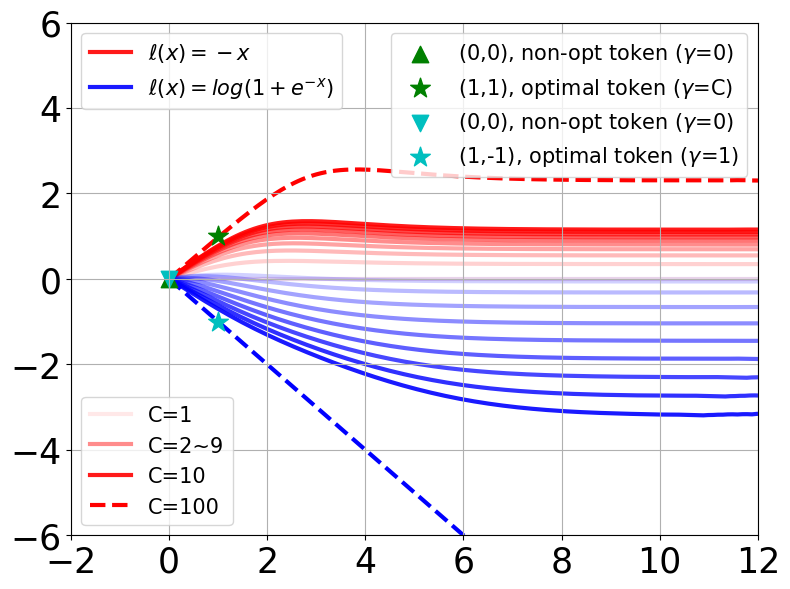

In [4]:

plt.figure(figsize=(8,6))
plt.scatter(X[0,0,0],X[0,0,1],marker='^',color='g',s=140, label=r'(0,0), non-opt token ($\gamma$=0)', zorder=1)
plt.scatter(X[0,1,0],X[0,1,1],marker='*',color='g',s=220, label=r'(1,1), optimal token ($\gamma$=C)', zorder=1)
plt.scatter(X[1,0,0],X[1,0,1],marker='v',color='c',s=140, label=r'(0,0), non-opt token ($\gamma$=0)', zorder=1)
plt.scatter(X[1,1,0],X[1,1,1],marker='*',color='c',s=220, label=r'(1,-1), optimal token ($\gamma$=1)', zorder=1)

colors = ['r','b','g']
THRED = 200
ls_loss = []
ls_Cs = []
for i in range(len(loss_type)):
    for j in range(len(Cs)-1):
        l, = plt.plot(ps[i,j,:THRED,0], ps[i,j,:THRED,1], linewidth=3, linestyle='-', color=colors[i], alpha=0.09* (j+1), zorder=-1)
        if i == 0:
            ls_Cs.append(l)
        if j == len(Cs)-2:
            ls_loss.append(l)
    l, = plt.plot(ps[i,-1,:THRED,0], ps[i,-1,:THRED,1], linewidth=3, linestyle='--', color=colors[i], alpha=1, zorder=-1)
    if i == 0:
        ls_Cs.append(l)


legend1 = plt.legend([ls_Cs[0],ls_Cs[4],ls_Cs[-2], ls_Cs[-1]], ['C=1','C=2~9','C=10','C=100'], loc=3, fontsize=15)
legend2 = plt.legend(ls_loss, [r"$\ell(x)=-x$", r'$\ell(x)=log(1+e^{-x})$', r"$\ell(x)=e^{-x}$"], loc=2, fontsize=15)
plt.legend(fontsize=15, loc='upper right')
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)

plt.xlim([-2,12])
plt.ylim([-6,6])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.grid()
plt.tight_layout()
plt.show()